# U-Net Keras final project


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image 
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
plt.style.use('ggplot')

### basic variable needed later:


In [ ]:
BATCH_SIZE = 16
EPOCHS=10
n_splits=5
fold_selected=2# 1..10
# fold_selected_test=[1,5]

### now we will download the mask of the images from *train.csv*

In [4]:
df = pd.read_csv('/kaggle/input/uw-madison-gi-tract-image-segmentation/train.csv')
print(df.shape)
df.head()

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


### visualize the data frame :

from here we are going the extract info from the dataframe and link every mask to its proper path as the mask and path are n't parallel to each other,we will do the following:
- the id column we will split it and make new columns for case number, day & slice number
- we gonna make a partial path with case number, day & slice number 
(as we know the true path has  the the same starting as partial path with some more info )
- then we will make another temp dataframe with the real path and split it and make partial path from it 
- finally we will join the to dataframe from partial path columns as a key so we make sure every mask got the true image path parllel to it 


In [5]:
df.rename(columns = {'class':'class_name'}, inplace = True)
#--------------------------------------------------------------------------
df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
df.head()

,id,class_name,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001
2,case123_day20_slice_0001,stomach,NaN,123,20,0001
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002


### we gonna make a partial path with case number, day & slice number
(as we know the true path has the the same starting as partial path with some more info )

In [6]:
TRAIN_DIR="/kaggle/input/uw-madison-gi-tract-image-segmentation/train"
# get all the image path with glob
all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)
x = all_train_images[0].rsplit("/", 4)[0] ## ../input/uw-madison-gi-tract-image-segmentation/train

path_partial_list = []
for i in range(0, df.shape[0]):
    path_partial_list.append(os.path.join(x,
                          "case"+str(df["case"].values[i]),
                          "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                          "scans",
                          "slice_"+str(df["slice"].values[i])))
df["path_partial"] = path_partial_list
df.head()

,id,class_name,segmentation,case,day,slice,path_partial
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmen...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmen...
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmen...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmen...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmen...


### then we will make another temp dataframe with the real path and split it and make partial path from it

In [7]:
path_partial_list = []
for i in range(0, len(all_train_images)):
    path_partial_list.append(str(all_train_images[i].rsplit("_",4)[0]))
    
tmp_df = pd.DataFrame()
tmp_df['path_partial'] = path_partial_list
tmp_df['path'] = all_train_images

tmp_df.head()

,path_partial,path
0,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...
1,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...
2,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...
3,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...
4,/kaggle/input/uw-madison-gi-tract-image-segmen...,/kaggle/input/uw-madison-gi-tract-image-segmen...


### finally we will join the to dataframe from partial path columns as a key so we make sure every mask got the true image path parllel to it 

In [8]:
df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
# -4 as we don't need the '.png'
df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
#--------------------------------------------------------------------------
del x,path_partial_list,tmp_df
#--------------------------------------------------------------------------
print(df.shape)
df.head(5)

(115488, 9)


,id,class_name,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266


### as we see each class name has it own row what we want is that each class name has a column

In [9]:
# RESTRUCTURE  DATAFRAME
df_train = pd.DataFrame({'id':df['id'][::3]})

df_train['large_bowel'] = df['segmentation'][::3].values
df_train['small_bowel'] = df['segmentation'][1::3].values
df_train['stomach'] = df['segmentation'][2::3].values

df_train['path'] = df['path'][::3].values
df_train['case'] = df['case'][::3].values
df_train['day'] = df['day'][::3].values
df_train['slice'] = df['slice'][::3].values
df_train['width'] = df['width'][::3].values
df_train['height'] = df['height'][::3].values


df_train.reset_index(inplace=True,drop=True)
df_train.fillna('',inplace=True); 
# the count columns store the number of mask the exist in image
df_train['count'] = np.sum(df_train.iloc[:,1:4]!='',axis=1).values
print(df_train.shape)
df_train.sample(5)

(38496, 11)


,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
19600,case24_day25_slice_0049,,,,/kaggle/input/uw-madison-gi-tract-image-segmen...,24,25,0049,266,266,0
11495,case9_day0_slice_0008,,,,/kaggle/input/uw-madison-gi-tract-image-segmen...,9,0,0008,360,310,0
16944,case147_day20_slice_0129,,,,/kaggle/input/uw-madison-gi-tract-image-segmen...,147,20,0129,266,266,0
31777,case144_day15_slice_0050,,,,/kaggle/input/uw-madison-gi-tract-image-segmen...,144,15,0050,266,266,0
29927,case29_day14_slice_0008,,,,/kaggle/input/uw-madison-gi-tract-image-segmen...,29,14,0008,266,266,0


### as we know from the data is that all the masks ar rle encoded so we need to make a decode function for that :

In [10]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(labels,input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask


##  we are gonna make data generator to get the image from the path and decode the masks of that image `"large_bowel","small_bowel","stomach" stored in red , green and blue channels sequently` and make them to batchs:


In [35]:
import keras
# we need to inherit from tf.keras.utils.Sequence to generat data
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.on_epoch_end()
# if we call the len() on the object this function will be called
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
# after the end of every epoch this function will be called  
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
# when the model.fit() called it call this function until it finish all the data
# we can call this function also by putting [] after the object 
    def __getitem__(self, index): 
        # make an empty holder for the image batch and masks batch
        X = np.empty((self.batch_size,128,128,3))
        y = np.empty((self.batch_size,128,128,3))
        # get the index of the wanted batch 
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get the path of every index to read the image
        for i,img_path in enumerate(self.df['path'].iloc[indexes]):
            # get the width and hight to decode the mask 
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            # read the image as gray scale
            img = self.__load_grayscale(img_path)
            # putting the batch holder
            X[i] =img
            # here we decode the mask and put in rgb image 
            if self.subset == 'train':
                for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
                    rles=self.df[j].iloc[indexes[i]]
                    masks = rle_decode(rles, shape=(h, w, 1))
                    #rles=df_train[j][df_train.index==indexes[i]]
                    #masks = build_masks(rles,(h,w), colors=False)
                    masks = cv2.resize(masks, (128, 128))
                    y[i,:,:,k] = masks
                    
        if self.subset == 'train': return X, y
        else: return X
       
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (128, 128)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        # normlize the image between 0 &1 
        img =(img - img.min())/(img.max() - img.min())
        
        return img
        


### generate data for every mask seperated by changing the value of channel: [0,1,2],["large_bowel","small_bowel","stomach"]

In [34]:
import keras
# we need to inherit from tf.keras.utils.Sequence to generat data
class DataGenerator1D(tf.keras.utils.Sequence):
    def __init__(self,channel, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.channel = channel
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.on_epoch_end()
# if we call the len() on the object this function will be called
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
# after the end of every epoch this function will be called  
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
# when the model.fit() called it call this function until it finish all the data
# we can call this function also by putting [] after the object 
    def __getitem__(self, index): 
        # make an empty holder for the image batch and masks batch
        X = np.empty((self.batch_size,128,128,3))
        y = np.empty((self.batch_size,128,128,1))
        # get the index of the wanted batch 
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get the path of every index to read the image
        for i,img_path in enumerate(self.df['path'].iloc[indexes]):
            # get the width and hight to decode the mask 
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            # read the image as gray scale
            img = self.__load_grayscale(img_path)
            # putting the batch holder
            X[i] =img
            # here we decode the mask and put in rgb image 
            if self.subset == 'train':
                for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
                    if self.channel == k:
                        rles=self.df[j].iloc[indexes[i]]
                        masks = rle_decode(rles, shape=(h, w,1))
                        #rles=df_train[j][df_train.index==indexes[i]]
                        #masks = build_masks(rles,(h,w), colors=False)
                        masks = cv2.resize(masks, (128, 128))
                        masks = np.expand_dims(masks, axis=-1)
                        y[i,:,:] = masks
                    
        if self.subset == 'train': return X, y
        else: return X
       
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (128, 128)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        # normlize the image between 0 &1 
        img =(img - img.min())/(img.max() - img.min())
        
        return img
        


In [13]:
# dd = DataGenerator1D(1,df_train[df_train.index.isin(train_ids)])

In [14]:
# image,mask = dd[1]

In [15]:
# mask.shape

In [16]:
# plt.imshow(image[7],cmap='gray')

> > # finally we finish preparing the data 

## here we are gonna make some viualization to get insite on the data :

### as we see from the below block of code that not all the image has the three mask present and we show the ratio of them

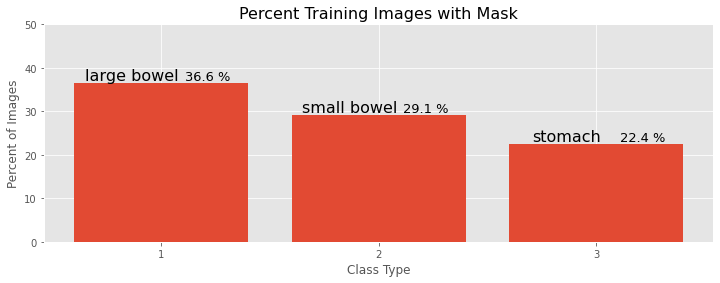

In [17]:
plt.figure(figsize=(12,4))
# specifying "large_bowel","small_bowel","stomach" columns to get the mean of every columns
bar = plt.bar([1,2,3],100*np.mean( df_train.iloc[:,1:4]!='',axis=0))

plt.title('Percent Training Images with Mask', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Class Type')
plt.xticks([1,2,3])
labels=["large bowel","small bowel","stomach"]

for rect,lbl in zip(bar,labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
             ha='center', va='bottom',fontsize=16)
    plt.text(rect.get_x() + rect.get_width()/1.3, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=13)

plt.ylim((0,50)); plt.show()

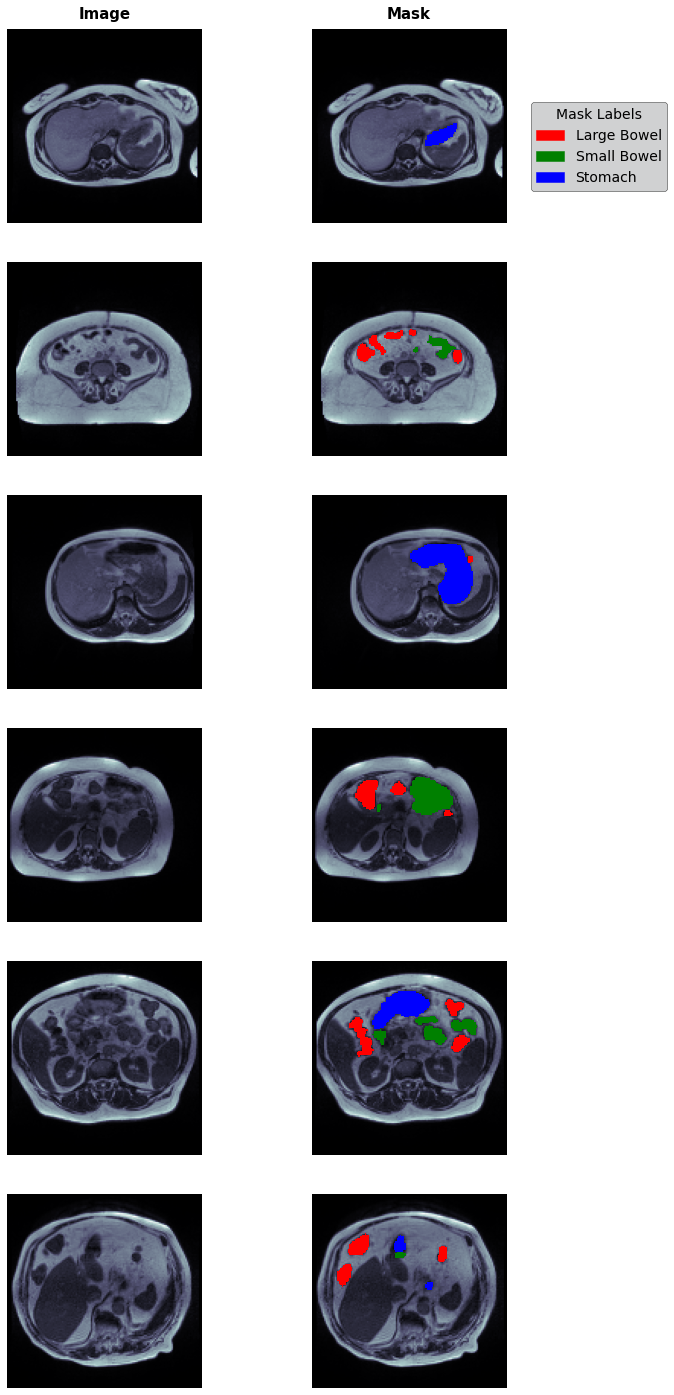

In [18]:
# SAMPLES
# BATCH_SIZE which we are sure that they have mask for large_bowel
Masks = list(df_train[df_train['large_bowel']!=''].sample(BATCH_SIZE).index)
# BATCH_SIZE*2 which we are sure that they have mask for small_bowel
Masks += list(df_train[df_train['small_bowel']!=''].sample(BATCH_SIZE*2).index)
# BATCH_SIZE*3 which we are sure that they have mask for stomach
Masks += list(df_train[df_train['stomach']!=''].sample(BATCH_SIZE*3).index)


# DATA GENERATOR
View_batches = DataGenerator(df_train[df_train.index.isin(Masks)],shuffle=True)

# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['red','green','blue']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = View_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

# Training

## splitting the data to train and validation and test:

> ### but before that we can see from below graph that nearly 2/3 of the data do n't have masks at all

<AxesSubplot:>

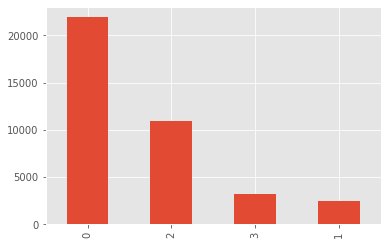

In [19]:
df_train["count"].value_counts().plot.bar()

> ### we will use StratifiedGroupKFold as it will split the data and make sure every group stay in the same batch ex: patient num 30 image will be in the same batch to make sure the train and test data don't leak to each other:
> 


In [20]:
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df_train, y=df_train['count'],groups =df_train['case']), 1):
    df_train.loc[val_idx, 'fold'] = fold
    
    
df_train['fold'] = df_train['fold'].astype(np.uint8)


test_ids = df_train[df_train["count"] == 0].index
train_ids = df_train[(df_train["fold"]!=fold_selected) & (~df_train.index.isin(test_ids))].index
valid_ids = df_train[(df_train["fold"]==fold_selected) & (~df_train.index.isin(test_ids))].index

df_train.groupby('fold').size()

fold
1    7920
2    6624
3    7952
4    8624
5    7376
dtype: int64

In [21]:
print(valid_ids.shape,test_ids.shape,train_ids.shape)

(2777,) (21906,) (13813,)


>## from this graph we can see that every fold is nearly has the same distribution :

<AxesSubplot:xlabel='fold,count'>

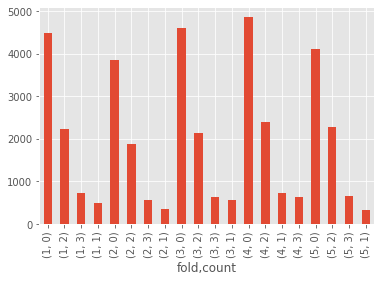

In [22]:
df_train.groupby(['fold'])['count'].value_counts().plot.bar()

> ## from the two below graph we can see that every ids(valid_ids and train_ids) is nearly has the same distribution  :

<AxesSubplot:>

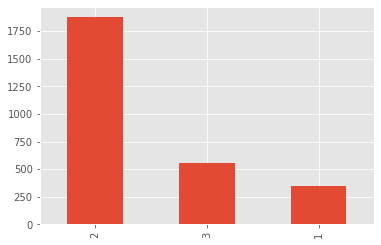

In [23]:
df_train.loc[valid_ids,:]['count'].value_counts().plot.bar()

<AxesSubplot:>

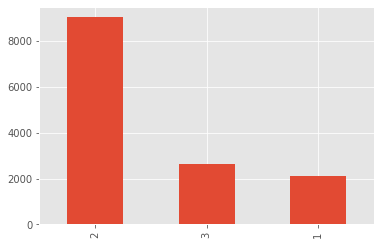

In [24]:
df_train.loc[train_ids,:]['count'].value_counts().plot.bar()

# creating the data generator :


In [36]:
train_generator = DataGenerator(df_train[df_train.index.isin(train_ids)],shuffle=True)
val_generator = DataGenerator(df_train[df_train.index.isin(valid_ids)])
# test_generator = DataGenerator(df_train[df_train.index.isin(test_ids)])
# every mask seperated
train_generator0 = DataGenerator1D(0,df_train[df_train.index.isin(train_ids)],shuffle=True)
val_generator0 = DataGenerator1D(0,df_train[df_train.index.isin(valid_ids)])

train_generator1 = DataGenerator1D(1,df_train[df_train.index.isin(train_ids)],shuffle=True)
val_generator1 = DataGenerator1D(1,df_train[df_train.index.isin(valid_ids)])

train_generator2 = DataGenerator1D(2,df_train[df_train.index.isin(train_ids)],shuffle=True)
val_generator2 = DataGenerator1D(2,df_train[df_train.index.isin(valid_ids)])

In [39]:
print("the number of batch in train data:\t",len(train_generator),"\n"
     "----------------------------------------------------------\n",
     "the number of batch in validation data:",len(val_generator),"\n"
     "----------------------------------------------------------\n",
#       "the number of batch in test data:\t",len(test_generator),"\n"
#      "----------------------------------------------------------\n",
     )

the number of batch in train data:	 863 
----------------------------------------------------------
 the number of batch in validation data: 173 
----------------------------------------------------------



# UNET model

> ### the loss & metric function:

In [1]:
! pip install segmentation-models

     -------------------------------------- 50.7/50.7 kB 642.3 kB/s eta 0:00:00
     -------------------------------------- 12.0/12.0 MB 188.0 kB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 1.1 MB/s eta 0:00:00
  Using cached networkx-2.8.8-py3-none-any.whl (2.0 MB)
     ------------------------------------ 210.3/210.3 kB 752.1 kB/s eta 0:00:00


In [41]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss,bce_dice_loss,cce_dice_loss,cce_jaccard_loss ,categorical_focal_dice_loss,categorical_focal_jaccard_loss,jaccard_loss,dice_loss
from segmentation_models.metrics import iou_score,f1_score,f2_score,precision,recall
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [42]:
from keras.callbacks import Callback, ModelCheckpoint , EarlyStopping
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

checkpoint1 = ModelCheckpoint(
    'model1.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

checkpoint2 = ModelCheckpoint(
    'model2.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

earlystop = EarlyStopping(monitor='loss', patience=7)

In [43]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)


In [44]:

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [45]:
# metrics=['accuracy', jacard_coef]
model1 =  multi_unet_model(n_classes=3, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=3)
# model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model1.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', jacard_coef,iou_score,f1_score,f2_score,precision,recall])

2023-01-04 18:15:45.621830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 18:15:45.773807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 18:15:45.774731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 18:15:45.776759: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [46]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [74]:
# model1.load_weights()

In [47]:
history1 = model1.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint1,earlystop],
    use_multiprocessing=False,
    workers=4,
    epochs=20
)

2023-01-04 18:16:02.085092: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-01-04 18:16:07.218987: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


863/863 [==============================] - 87s 87ms/step - loss: 0.3408 - accuracy: 0.4633 - jacard_coef: 0.2844 - iou_score: 0.2676 - f1-score: 0.3959 - f2-score: 0.4159 - precision: 0.3879 - recall: 0.4414 - val_loss: 0.2352 - val_accuracy: 0.3624 - val_jacard_coef: 0.4524 - val_iou_score: 0.3642 - val_f1-score: 0.4919 - val_f2-score: 0.5163 - val_precision: 0.4939 - val_recall: 0.6691

Epoch 00001: val_loss improved from inf to 0.23521, saving model to model1.h5
Epoch 2/20
863/863 [==============================] - 61s 70ms/step - loss: 0.1888 - accuracy: 0.5707 - jacard_coef: 0.5192 - iou_score: 0.5200 - f1-score: 0.6795 - f2-score: 0.6872 - precision: 0.6780 - recall: 0.6955 - val_loss: 0.2060 - val_accuracy: 0.4214 - val_jacard_coef: 0.5166 - val_iou_score: 0.4146 - val_f1-score: 0.5379 - val_f2-score: 0.5423 - val_precision: 0.5718 - val_recall: 0.6728

Epoch 00002: val_loss improved from 0.23521 to 0.20599, saving model to model1.h5
Epoch 3/20
863/863 [=========================

In [50]:
model1.save_weights("model1.h5")

In [48]:
hist_df1 = pd.DataFrame(history1.history)
hist_df1.to_csv('history1.csv')
hist_df1

,loss,accuracy,jacard_coef,iou_score,f1-score,f2-score,precision,recall,val_loss,val_accuracy,val_jacard_coef,val_iou_score,val_f1-score,val_f2-score,val_precision,val_recall
0,0.340756,0.463306,0.284412,0.267597,0.395852,0.415931,0.387888,0.441363,0.235206,0.362356,0.452392,0.364165,0.491941,0.516259,0.493853,0.669124
1,0.188805,0.570686,0.519202,0.519984,0.679452,0.687161,0.678038,0.695455,0.205993,0.421411,0.516568,0.414606,0.537920,0.542332,0.571849,0.672840
2,0.151616,0.530027,0.595168,0.600142,0.746177,0.750427,0.745978,0.755099,0.196112,0.598481,0.538099,0.435180,0.558389,0.568379,0.581683,0.703333
3,0.132279,0.600216,0.637639,0.643483,0.779606,0.782552,0.779053,0.785652,0.190920,0.596264,0.549513,0.450064,0.573360,0.569507,0.617429,0.693297
4,0.123848,0.637006,0.657069,0.662845,0.794064,0.796470,0.794125,0.799113,0.177544,0.765271,0.576278,0.474206,0.594233,0.595114,0.628697,0.722057
5,0.116419,0.644400,0.674663,0.680771,0.807056,0.809664,0.806183,0.812306,0.189333,0.507024,0.557052,0.462667,0.586395,0.588893,0.623443,0.719506
6,0.111906,0.628990,0.685200,0.691699,0.815076,0.817785,0.813816,0.820428,0.166876,0.906096,0.599073,0.491790,0.610702,0.625110,0.617819,0.760773
7,0.108739,0.683015,0.693027,0.699700,0.820725,0.823155,0.819806,0.825601,0.168409,0.508548,0.595698,0.492509,0.611065,0.622347,0.622469,0.756865
8,0.105769,0.645322,0.700103,0.705929,0.825123,0.827135,0.824527,0.829180,0.161081,0.817997,0.608742,0.504162,0.621881,0.627875,0.640410,0.757393
9,0.102560,0.716472,0.707723,0.713853,0.830694,0.833062,0.829293,0.835304,0.168595,0.644046,0.598212,0.497755,0.616551,0.603752,0.672175,0.717321


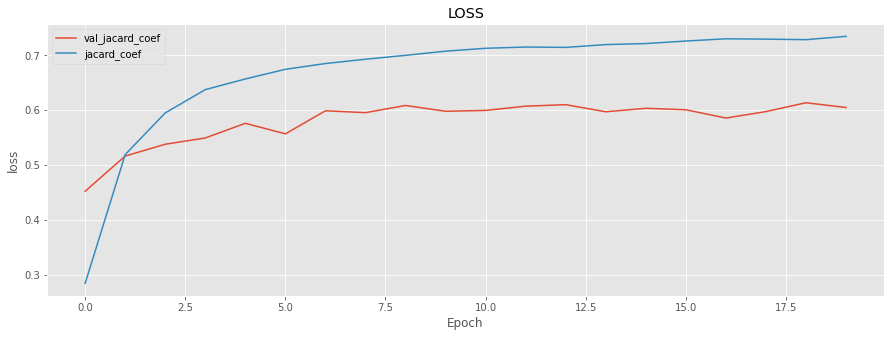

In [51]:
plt.figure(figsize=(15,5))
plt.plot(range(history1.epoch[-1]+1),history1.history['val_jacard_coef'],label='val_jacard_coef')
plt.plot(range(history1.epoch[-1]+1),history1.history['jacard_coef'],label='jacard_coef')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

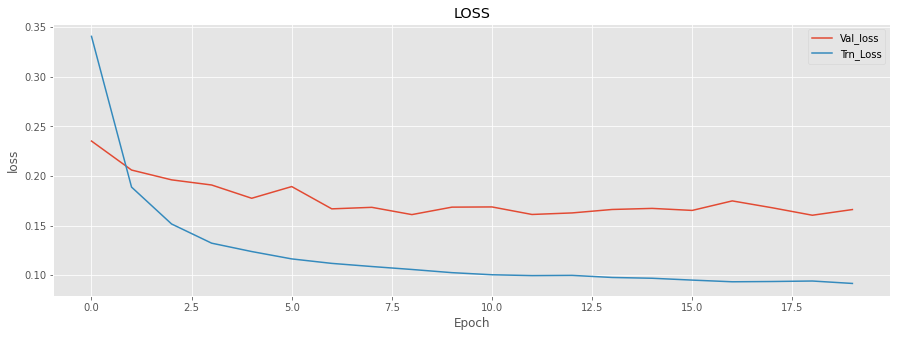

In [49]:
plt.figure(figsize=(15,5))
plt.plot(range(history1.epoch[-1]+1),history1.history['val_loss'],label='Val_loss')
plt.plot(range(history1.epoch[-1]+1),history1.history['loss'],label='Trn_Loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

In [86]:
# ! pip install git+https://github.com/qubvel/segmentation_models

In [54]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet('efficientnetb7',input_shape=(128, 128,3), classes=3, activation='sigmoid', encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef,f1_score,f2_score,precision,recall,iou_score])
# model.summary()
# model = Unet('efficientnetb7',input_shape=(128, 128, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')
# model.compile(optimizer='adam', loss=bce_dice_loss,metrics=[dice_coef,iou_coef,'accuracy']) #binary_crossentropy
# model.summary()

# Training model

In [55]:
for layer in model.layers[:500]:
    layer.trainable=False

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 64, 64, 64)   1728        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 64, 64, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 64, 64, 64)   0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [56]:
# for i in range(750):
#     model.layers[i].set_trainable = False   
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint,earlystop],
    use_multiprocessing=False,
    workers=4,
    epochs=13
)

Epoch 1/13
863/863 [==============================] - 335s 349ms/step - loss: 0.2119 - dice_coef: 0.6610 - f1-score: 0.6608 - f2-score: 0.6854 - precision: 0.6393 - recall: 0.7273 - iou_score: 0.5277 - val_loss: 0.1599 - val_dice_coef: 0.7406 - val_f1-score: 0.6047 - val_f2-score: 0.5896 - val_precision: 0.6656 - val_recall: 0.7011 - val_iou_score: 0.4839

Epoch 00001: val_loss improved from inf to 0.15990, saving model to model.h5
Epoch 2/13
863/863 [==============================] - 297s 344ms/step - loss: 0.1041 - dice_coef: 0.8240 - f1-score: 0.8272 - f2-score: 0.8326 - precision: 0.8217 - recall: 0.8371 - iou_score: 0.7093 - val_loss: 0.1410 - val_dice_coef: 0.7754 - val_f1-score: 0.6463 - val_f2-score: 0.6383 - val_precision: 0.6829 - val_recall: 0.7530 - val_iou_score: 0.5305

Epoch 00002: val_loss improved from 0.15990 to 0.14099, saving model to model.h5
Epoch 3/13
863/863 [==============================] - 297s 344ms/step - loss: 0.0894 - dice_coef: 0.8491 - f1-score: 0.8524 

In [75]:
model.save("model0.h5")

In [58]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

In [59]:
hist_df

,loss,dice_coef,f1-score,f2-score,precision,recall,iou_score,val_loss,val_dice_coef,val_f1-score,val_f2-score,val_precision,val_recall,val_iou_score
0,0.211861,0.661043,0.660786,0.685437,0.639343,0.727347,0.527699,0.159905,0.740567,0.604655,0.589579,0.665584,0.701129,0.483854
1,0.104080,0.824013,0.827217,0.832558,0.821716,0.837096,0.709278,0.140988,0.775351,0.646318,0.638264,0.682887,0.752985,0.530539
2,0.089421,0.849136,0.852420,0.856797,0.847492,0.860349,0.745761,0.138511,0.780740,0.652860,0.656231,0.669844,0.781287,0.539123
3,0.080251,0.864552,0.867506,0.871451,0.862735,0.874560,0.768357,0.145392,0.774512,0.646973,0.641012,0.686240,0.758556,0.532046
4,0.075872,0.871973,0.875014,0.878549,0.870570,0.881288,0.779897,0.137398,0.785461,0.658005,0.652857,0.689173,0.770417,0.545273
5,0.071900,0.878588,0.881332,0.884517,0.877240,0.886961,0.789726,0.147233,0.773247,0.645679,0.633388,0.697775,0.746403,0.531245
6,0.068062,0.884992,0.887646,0.890564,0.883817,0.892779,0.799576,0.145499,0.776399,0.643152,0.635353,0.688215,0.751709,0.529932
7,0.066398,0.887783,0.890374,0.892857,0.887273,0.894783,0.803939,0.146757,0.776671,0.650625,0.639880,0.693665,0.753430,0.538075
8,0.062860,0.893693,0.896198,0.898601,0.892976,0.900405,0.813203,0.148419,0.777579,0.650996,0.647330,0.683784,0.765968,0.538834
9,0.062272,0.894673,0.897083,0.899455,0.893949,0.901248,0.814680,0.149619,0.771765,0.641060,0.632905,0.679216,0.749819,0.526984


In [98]:
# PLOT TRAINING
# plt.figure(figsize=(15,5)
# plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
# plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='dice_coef')
# plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 
# plt.show()

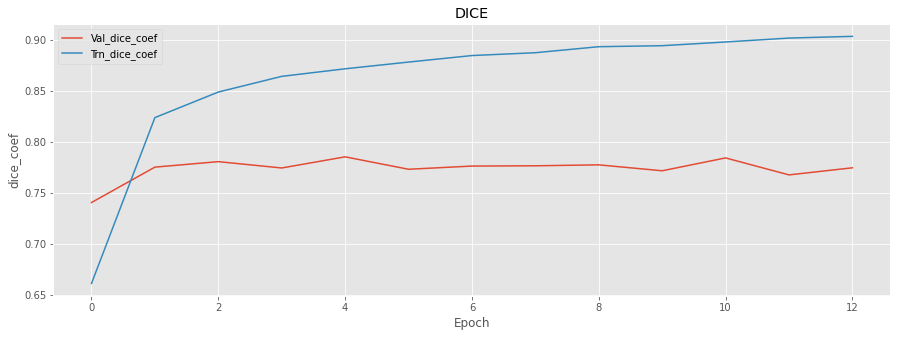

In [60]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Trn_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 
plt.show()

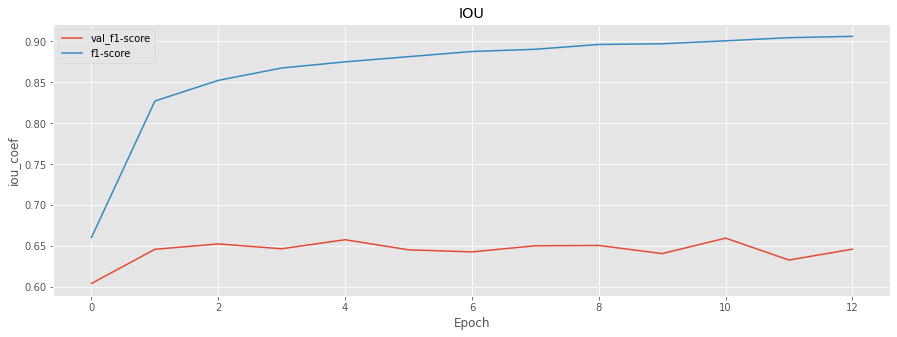

In [62]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_f1-score'],label='val_f1-score')
plt.plot(range(history.epoch[-1]+1),history.history['f1-score'],label='f1-score')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend()
plt.show()

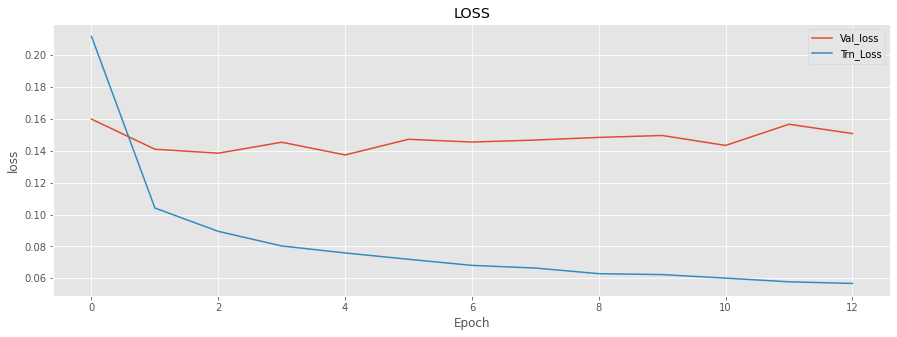

In [63]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Trn_Loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

# Predict From Valiation Set 

In [24]:
# custom_objects = custom_objects={
#     'dice_coef': dice_coef,
#     'iou_coef': iou_coef,
#     'bce_dice_loss': bce_dice_loss  
# }
# model = load_model('./model.h5', custom_objects=custom_objects)

In [77]:
pred_batches = DataGenerator(df_train[df_train.index.isin(valid_ids[20:28])],batch_size = 1,shuffle=True)
preds = model.predict_generator(pred_batches,verbose=1)

8/8 [==============================] - 0s 40ms/step


IndexError: index 8 is out of bounds for axis 0 with size 8

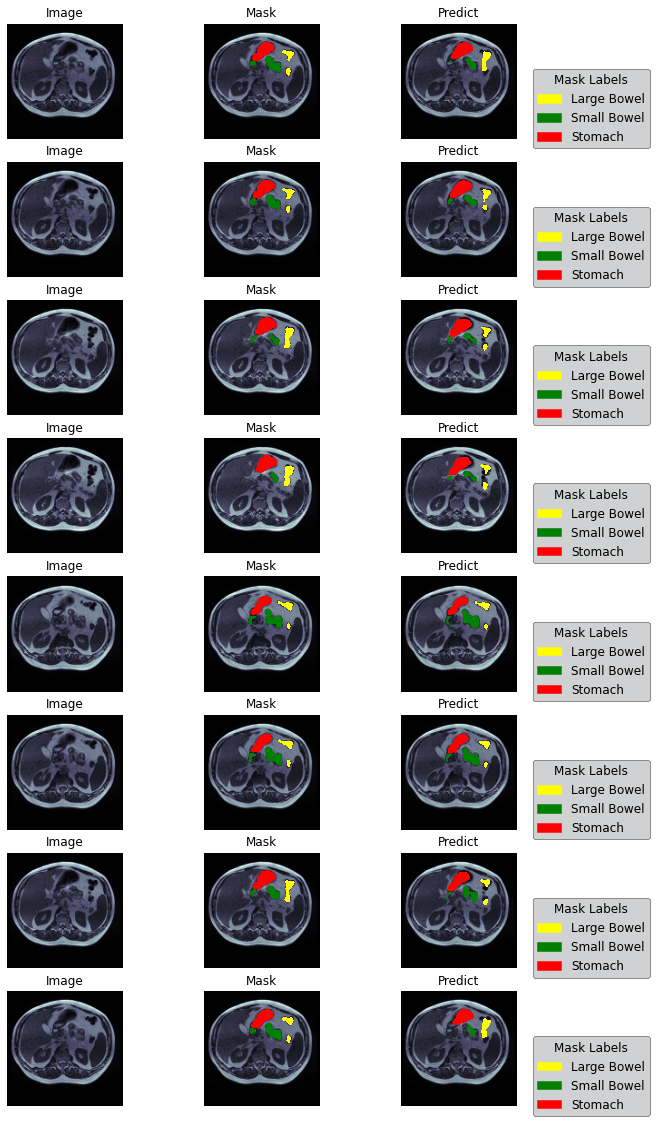

In [78]:
Threshold = 0.1
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=10, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(10):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')


In [76]:
from IPython.display import FileLink
# FileLink(r'Images_zeros.npy')

FileLink(r'model0.h5')

/kaggle/working/model0.h5